In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Bagian 1. Pemrosesan Dataset


**Mengimpor Fungsi Library**

In [1]:
#Import Library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

**Mengimpor Dataset**

In [2]:
dataset_train = pd.read_csv('dataset_LSTM_Multivariat.csv')
df=pd.read_csv('dataset_LSTM_Multivariat.csv', delimiter=';')
print('Number of rows and columns:', df.shape)
df.head(10)

Number of rows and columns: (2394, 9)


,date,u1,u2,u3,u4,u5,u6,u7,y
0,01/01/2000,0.2689,0.6509,0.8327,0.5834,0.7848,0.8431,0.8221,0.1803
1,02/01/2000,0.2685,0.6501,0.8522,0.5775,0.7765,0.8386,0.8221,0.1771
2,03/01/2000,0.2680,0.6597,0.8236,0.5716,0.7645,0.8079,0.7862,0.1736
3,04/01/2000,0.2675,0.6683,0.8084,0.5657,0.7526,0.7996,0.7862,0.1716
4,05/01/2000,0.2669,0.6472,0.7619,0.5598,0.7453,0.7731,0.7461,0.1670
5,06/01/2000,0.2664,0.6337,0.7746,0.5551,0.7561,0.8113,0.7864,0.1637
6,07/01/2000,0.2659,0.6540,0.7744,0.5518,0.7668,0.8517,0.8208,0.1602
7,08/01/2000,0.2654,0.6723,0.7740,0.5484,0.7612,0.8056,0.8221,0.1582
8,09/01/2000,0.2635,0.6393,0.7621,0.5451,0.7532,0.8112,0.7890,0.1570
9,10/01/2000,0.2527,0.6622,0.7704,0.5418,0.7453,0.8132,0.7890,0.1548


**3. Memperbaiki Data**

In [ ]:
#Repair Data
df['date_time'] = pd.to_datetime(df['date'])
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df = df.dropna(subset=['y'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','y', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (2394, 7)
The time series starts from:  2000-01-01 00:00:00
The time series ends on:  2006-12-07 00:00:00


**Pengecekan Skewness Dataset**

Statistics=839.166, p=0.000
Data does not look Gaussian (reject H0)
Kurtosis of normal distribution: 4.473499707734145
Skewness of normal distribution: 1.7088150777582334


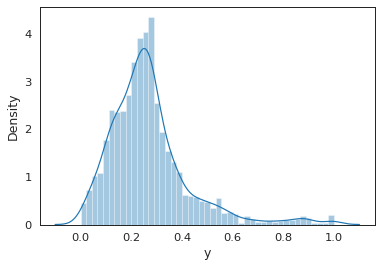

In [ ]:
#Statistical Normality Test
#p <= alpha: reject H0, not normal.
#p > alpha: fail to reject H0, normal.

stat, p = stats.normaltest(df.y)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

sns.distplot(df.y);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.y)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.y)))

# Bagian 2. Pembuatan Model Pelatihan

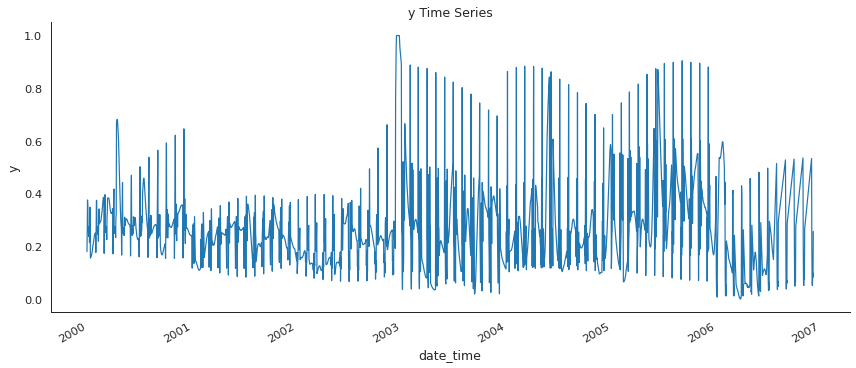

In [ ]:
#First Time Series Plot
df1=df.loc[:,['date_time','y']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('y')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('y Time Series')
sns.despine(top=True)
plt.show();

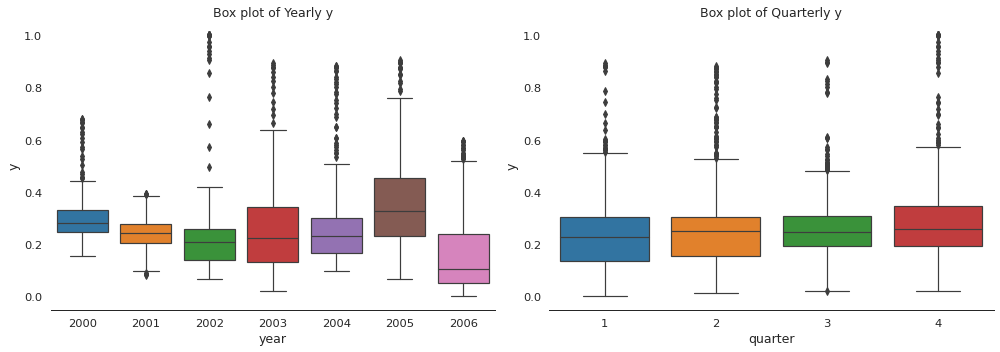

In [ ]:
#Box Plot of Yearly vs. Quarterly y
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="y", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly y')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="y", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly y')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
y,2394.0000,0.2678,0.1589,0.0000,0.1692,0.2469,0.3181,1.0000


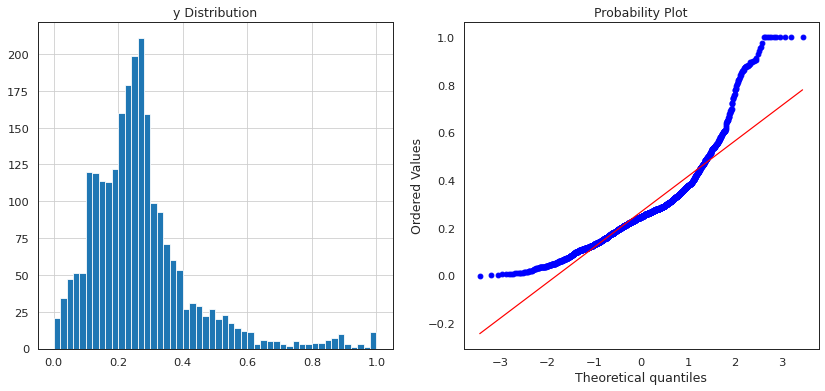

In [ ]:
#y Distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['y'].hist(bins=50)
plt.title('y Distribution')
plt.subplot(1,2,2)
stats.probplot(df['y'], plot=plt);
df1.describe().T

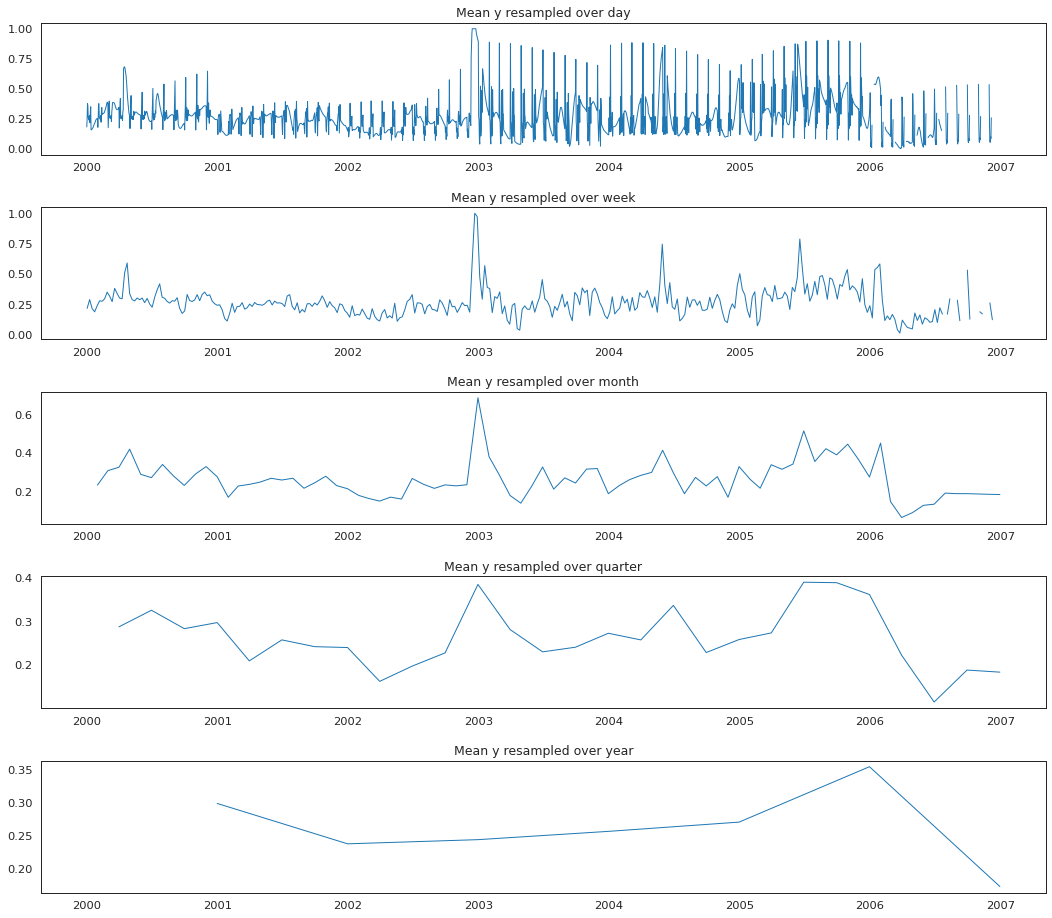

In [ ]:
#Average y Resampled Over Day, Week, Month, Quarter and Year
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['y'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean y resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['y'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean y resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['y'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean y resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['y'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean y resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['y'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean y resampled over year')
ax5.tick_params(axis='both', which='major');

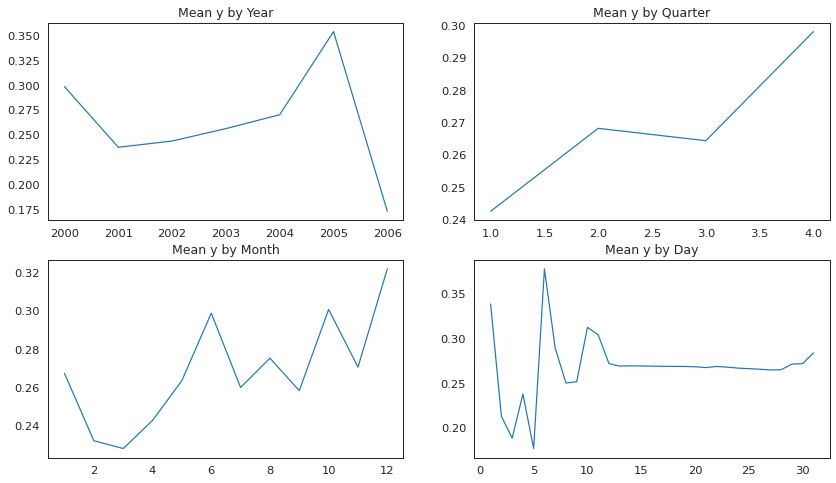

In [ ]:
#Plot Mean y Grouped by Year, Quarter, Month and Day
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').y.agg('mean').plot()
plt.xlabel('')
plt.title('Mean y by Year')

plt.subplot(2,2,2)
df.groupby('quarter').y.agg('mean').plot()
plt.xlabel('')
plt.title('Mean y by Quarter')

plt.subplot(2,2,3)
df.groupby('month').y.agg('mean').plot()
plt.xlabel('')
plt.title('Mean y by Month')

plt.subplot(2,2,4)
df.groupby('day').y.agg('mean').plot()
plt.xlabel('')
plt.title('Mean y by Day');

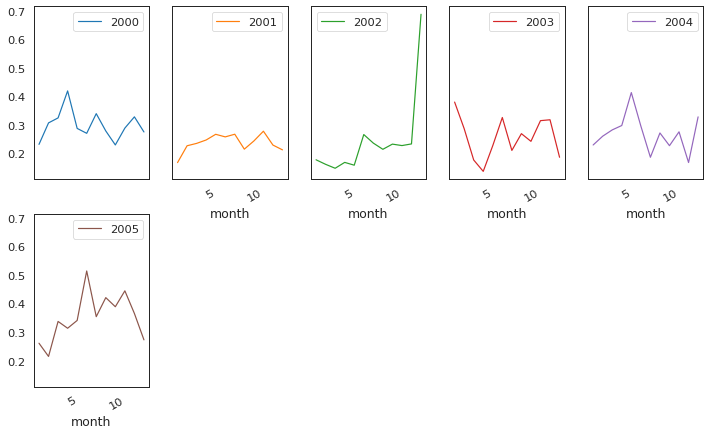

In [ ]:
#y by Years
pd.pivot_table(df.loc[df['year'] != 2006], values = "y", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

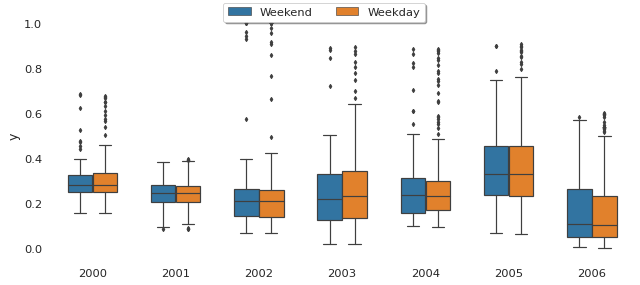

In [ ]:
#y in Weekdays vs. Weekends
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','y',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

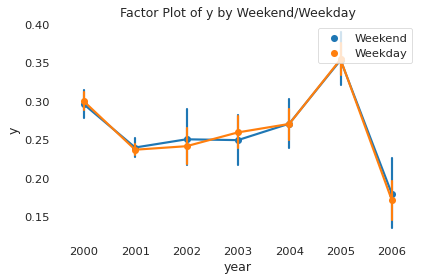

In [ ]:
#Factor Plot of y by Weekday vs. Weekend
plt1=sns.factorplot('year','y',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of y by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

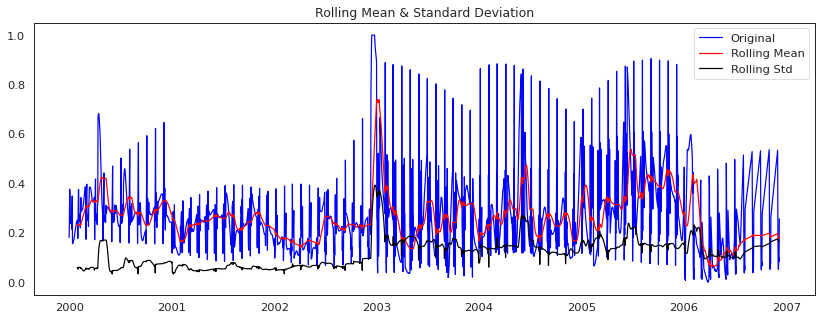

<Results of Dickey-Fuller Test>
Test Statistic                  -6.0945
p-value                          0.0000
#Lags Used                      27.0000
Number of Observations Used   2366.0000
Critical Value (1%)             -3.4331
Critical Value (5%)             -2.8628
Critical Value (10%)            -2.5674
dtype: float64


In [ ]:
#Dickey-Fuller test
#Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
#Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
#p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

df2=df1.resample('D').mean()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.y.dropna())


**Membangun Neural Network berbasis LSTM**

In [ ]:
#LSTM
#The following data pre-processing and feature engineering need to be done before construct the LSTM model.
#Normalize the features.
#Split into training and test sets.
#Convert an array of values into a dataset matrix.
#Reshape into X=t and Y=t+1.
#Reshape input to be 3D (num_samples, num_timesteps, num_features).

dataset = df.y.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

**Memulai Training**

In [ ]:
#Model Architecture
#Define the LSTM with 1000 neurons in the first hidden layer and 1 neuron in the output layer for predicting y. The input shape will be 1 time step with 30 features.
#Dropout 20%.
#Use the MSE loss function and the efficient Adam version of stochastic gradient descent.
#The model will be fit for 20 training epochs with a batch size of 70.

model = Sequential()
model.add(LSTM(1000, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=100, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/100
27/27 [==============================] - 5s 93ms/step - loss: 0.0297 - val_loss: 0.0256
Epoch 2/100
27/27 [==============================] - 2s 74ms/step - loss: 0.0160 - val_loss: 0.0232
Epoch 3/100
27/27 [==============================] - 2s 74ms/step - loss: 0.0141 - val_loss: 0.0225
Epoch 4/100
27/27 [==============================] - 2s 74ms/step - loss: 0.0134 - val_loss: 0.0223
Epoch 5/100
27/27 [==============================] - 2s 76ms/step - loss: 0.0131 - val_loss: 0.0225
Epoch 6/100
27/27 [==============================] - 2s 79ms/step - loss: 0.0130 - val_loss: 0.0228
Epoch 7/100
27/27 [==============================] - 2s 76ms/step - loss: 0.0129 - val_loss: 0.0229
Epoch 8/100
27/27 [==============================] - 2s 79ms/step - loss: 0.0129 - val_loss: 0.0228
Epoch 9/100
27/27 [==============================] - 2s 78ms/step - loss: 0.0130 - val_loss: 0.0232
Epoch 10/100
27/27 [==============================] - 2s 78ms/step - loss: 0.0129 - val_loss: 0.0228

# Bagian 3. Membuat Prediksi

In [ ]:
#Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.06822192812468975
Train Root Mean Squared Error: 0.11255187094441489
Test Mean Absolute Error: 0.1005913673231719
Test Root Mean Squared Error: 0.15049186894460528


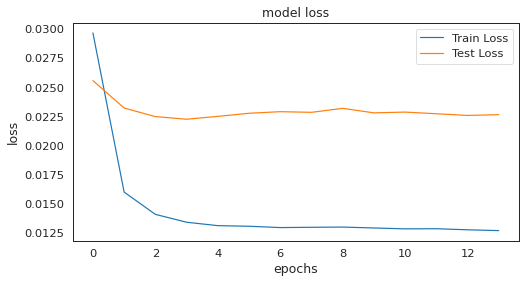

In [ ]:
#Plot Model Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();


**Menampilkan Hasil Prediksi**

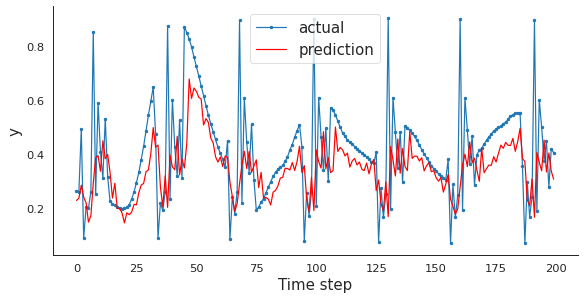

In [ ]:
#Compare Actual vs. Prediction
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('y', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();